# Ethereum Price Prediction Using LSTMs 

# Loading Basic Libraries

In [1]:
from google.cloud import bigquery
import tensorflow as tf
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

import datetime
import requests
import sys, os

#changing default figure renderer for github display
import plotly.io as pio
pio.renderers
pio.renderers.default = "svg"

# Defining Basic Plotting Functions

In [14]:
def plotData(df, x_column, y_column): 
    """simply the input plot data from a dataframe"""

    figure = go.Figure()
    figure.add_trace(go.Scatter(x=df[x_column],y=df[y_column],mode='lines'))
    
    figure.update_xaxes(title = "Time")
    figure.update_yaxes(title = "Price")
    
    figure.show()
    
def plotArrays(train, prediction, plotBoth=False): 
    '''plots the training dataset array.
    The "plotBoth" flag plots predictions in addition to just the training data.
    Note the .ravel function flattens an array'''
    
    figure = go.Figure()
    figure.add_trace(go.Scatter(y=train.ravel()
                               ,x=list(range(len(train.ravel()))),
                               mode='lines',
                               name="labels"
                               )
                        )
    
    if plotBoth:
        figure.add_trace(go.Scatter(y=prediction.ravel()
                               ,x=list(range(len(prediction.ravel()))),mode='lines',
                                name = "prediction"
                                )
                        )
        
    figure.update_xaxes(title = "Time")
    figure.update_yaxes(title = "Normalized Price")
    
    figure.show()

# Defining API calls for Ethereum Prices


In [3]:
#Documentation and explanation of the API request can be found here:
#https://min-api.cryptocompare.com/documentation?

#my api key:
my_api_key = '72183b21006f095800f3b2e4b665adaae27d08098ec380c72b3ee87d25c8164f'

#Obtain price of a cryptocurrency right now
def price(symbol, comparison_symbols=['USD'], exchange=''):
    url = 'https://min-api.cryptocompare.com/data/price?fsym={}&tsyms={}&api_key={}'\
            .format(symbol.upper(), ','.join(comparison_symbols).upper(),my_api_key)
    
    #this would be the same as the following code for ETH price and BTC,USD,EUR comparisons
    #url = 'https://min-api.cryptocompare.com/data/price?fsym=ETH & tsyms=BTC,USD,EUR & api_key={my_api_key}'

    #adding the exchange if we want a specefic exchange
    if exchange:
        url += '&e={}'.format(exchange) 
        
    page = requests.get(url)
    data = page.json()
    return data

    #example use: 
    #price('LTC', exchange='Coinbase')

#Get historical price with daily timestep
def daily_price_historical(symbol, comparison_symbol, limit=1, aggregate=1, exchange='', allData='true'):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}&allData={}&api_key={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate, allData,my_api_key)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time] #seting up timestamp from time column
    return df

    #example use:
    #df = daily_price_historical('BTC', 'USD')
    #print('Max length = %s' % len(df))
    #print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))
    #df.head()

#Get historical price with hourely timestep
def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}&api_key={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate,my_api_key)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

    #example use:
    #time_delta = 1 # Bar width in hours
    #df = hourly_price_historical('BTC', 'USD', 9999, time_delta)
    #print('Max length = %s' % len(df))
    #print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

#Get historical price with minute timestep
def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}&api_key={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate,my_api_key)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

    #example use:
    #time_delta = 1 # Bar width in minutes
    #df = minute_price_historical('BTC', 'USD', 9999, time_delta)
    #print('Max length = %s' % len(df))
    #print('Max time = %s' % (df.timestamp.max() - df.timestamp.min()))

# Obtaining and Viewing Data

Max length = 4070
Max time = 4069 days 00:00:00


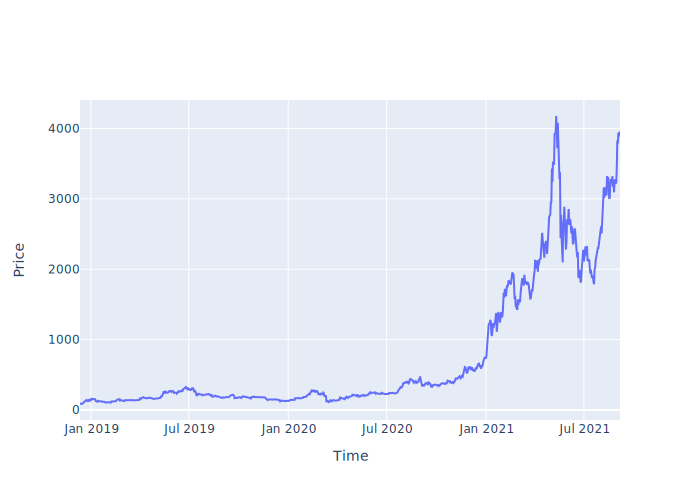

In [13]:
price_daily = daily_price_historical('ETH', 'USD')
print('Max length = %s' % len(price_daily))
print('Max time = %s' % (price_daily.timestamp.max() - price_daily.timestamp.min()))
price_daily.tail()

plotData(price_daily.iloc[-1000:],"timestamp","close")

# Setting up RNN Configuration

In [5]:
#LSTM setup roughtly follows the following configuration: 
#https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html

class configurationRNN():
    """
    We will place the model configuration within a single object for easier handling
    Note that the if-else statements are done to create default values in the constructor
    """
    
    def __init__(self, input_size=None, grouped_inputs=None,
                 input_overlap=None, layer_size=None, num_layers=None,
                keep_prob=None, start_learning_rate=None, initial_epochs=None,
                decay_learning_rate=None, max_epochs=None, batch_size=None):
    
        # number of time inputs into a single time-step in the RNN. (size of sliding window/1 data point)
        if input_size is None:
            self.input_size = 3
        else:
            self.input_size = input_size       
    
        # number of inputs used during a training instance the "unrolled" version of the RNN
        if grouped_inputs is None:
            self.grouped_inputs = 2
        else:
            self.grouped_inputs = grouped_inputs
            
        #note a single training data set is going to have the size of input_size*grouped_inputs
    
        #overlap beetween windows when choosing input data 
        #(i.e. does the next input contain values from the previous one?)
        if input_overlap is None:
            self.input_overlap = 3
        else:
            self.input_overlap = input_overlap
        
        #setting number of units in an LSTM layer (layer size)
        if layer_size is None:
            self.layer_size = 128
        else:
            self.layer_size = layer_size
        
        #setting number of stacked LSTM layers (number of layers)
        if num_layers is None:
            self.num_layers = 1
        else:
            self.num_layers = num_layers

        #percentage of cell units to keep in the dropout operation during training
        if keep_prob is None:
            self.keep_prob = 0.8
        else:
            self.keep_prob = keep_prob
        
        #setting start learning rate 
        if start_learning_rate is None:
            self.start_learning_rate = 0.001
        else:
            self.start_learning_rate = start_learning_rate

        #setting number of epochs we will use initial learning rate
        if initial_epochs is None:
            self.decay_learning_rate = 5
        else:
            self.initial_epochs = initial_epochs

        #setting decay in learning rate after 1st epoch
        if decay_learning_rate is None:
            self.decay_learning_rate = 0.99
        else:
            self.decay_learning_rate = decay_learning_rate

        #maximum number of epochs used for training
        if max_epochs is None:
            self.max_epochs = 3
        else:
            self.max_epochs = max_epochs

        #setting mini batch size
        if batch_size is None:
            self.batch_size = 64
        else:
            self.batch_size = batch_size

# Preparing Data for RNN

In [6]:
def prepare_data(df,num_time_steps,train_test_split,config):
    """Function to split the raw data into time-step separated training and testing data"""
    
    #making a list sequence of closing prices
    l = []
    for i in df.iloc[-num_time_steps:]["close"]:
        l.append(i)
                
    #formatting the data into a list of arrays (a 3-D array)
    #each array has the size of the number of time steps included in each input
    #each array does not share numbers with previous array (we can change that)

    seq = [np.array(
                l[config.input_size*i : config.input_size*(i + 1)]
                ) 
           for i in range(len(l) // config.input_size)
          ]

    #non dimensionalize with respect to last unkwnown value in previous window
    seq_ref = seq.copy()
    seq[0] = seq_ref[0]/seq_ref[0][0] #first window normalization is different
 
    for i in range(1,len(seq)):
        seq[i] = seq_ref[i]/seq_ref[i-1][-1]

    # group inputs by "grouped inputs" parameter (how many inputs are used as a training istance in unrolled version RNN)
    features = np.array([seq[i: i + config.grouped_inputs] for i in range(len(seq) - config.grouped_inputs)])
    labels = np.array([seq[i + config.grouped_inputs] for i in range(len(seq) - config.grouped_inputs)])
    
    #splitting the train-test data 
    cutoff = int(features.shape[0]*train_test_split)
    
    train_data = features[:cutoff]
    train_labels = labels[:cutoff]
    test_data = features[cutoff:]
    test_labels = labels[cutoff:]
    
    return train_data, train_labels, test_data, test_labels, np.array(seq)

# Setting up RNN model constructor function

In [7]:
#defining the model

def build_lstm_model(config):
    model = Sequential() #linear stack of layers
    
    model.add(LSTM(config.layer_size,
                input_shape =(config.grouped_inputs, config.input_size), #input shape
                return_sequences = True #neccesary if multiple LSTM layers
                )
             )
    
    for i in range(config.num_layers-2):
        model.add(LSTM(config.layer_size,
                recurrent_dropout = (1-config.keep_prob), #dropout layer of the outputs
                return_sequences = True)
                 )
        
    model.add(LSTM(config.layer_size,
                recurrent_dropout = (1-config.keep_prob))
             )
        
    model.add(Dense(units = config.input_size))
             
    #model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
    model.compile(optimizer="RMSprop", loss="mse", metrics=["mae","mse"])

    return model


# Defining pipleine for running and testing the model

In [8]:
def run_model(df,total_steps,config):

    #run data preparation
    train_data, train_labels, test_data, test_labels, full_data = prepare_data(df,total_steps,0.8,config)
    print("shape training data = " + str(train_data.shape))
    print("shape testing data = " + str(test_data.shape))
    
    #build model
    model =  build_lstm_model(config)
    #model.summary()
    
    #fit model and predict 
    model.fit(train_data,train_labels, epochs = config.max_epochs)
    prediction = model.predict(test_data)
    
    plotArrays(test_labels,prediction,True)
    

# Running the Model

shape training data = (158, 2, 5)
shape testing data = (40, 2, 5)
Epoch 1/3
5/5 [==============================] - 6s 16ms/step - loss: 0.9276 - mae: 0.9571 - mse: 0.9276
Epoch 2/3
5/5 [==============================] - 0s 19ms/step - loss: 0.1631 - mae: 0.3326 - mse: 0.1631
Epoch 3/3
5/5 [==============================] - 0s 15ms/step - loss: 0.0214 - mae: 0.1239 - mse: 0.0214


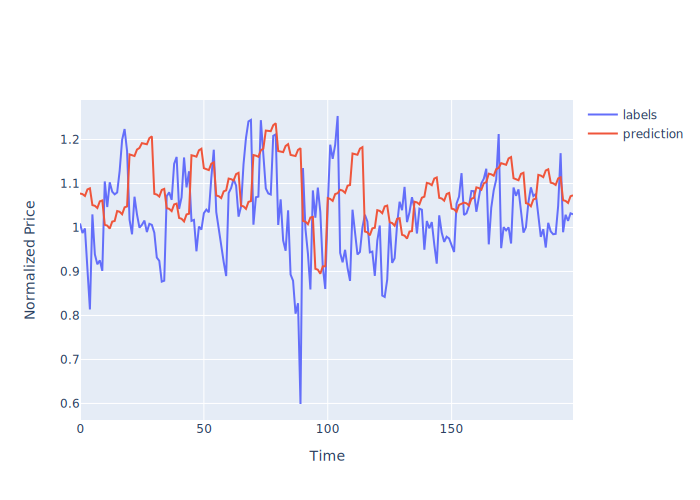

In [16]:
#run configuration and model
config1 = configurationRNN(input_size=5,num_layers=3)    
run_model(price_daily,1000,config1)

Things left to do:
    -use word embeddings for reddit posts (instead of bag of words)
    -change aronud input size, grouped inputs, and input overalp. 
    -move around normalization value (it could just be last data point in previous sample)
    -subtract 1 to make negative movements negative and positive movements positive
    -can use different defenitions of the lstm cell (GRUs)
    -make the NN a functional (not sequential) network, where layers can connect to many other layers. 